In [746]:
import geopandas as gpd
from matplotlib import pyplot as plt
import cartopy
import networkx as nx
import networkx.algorithms as algos
from functools import partial
from importlib import reload

import functions
reload(functions)

<module 'functions' from '/Users/hugoschwabe/Documents/Code/bachelor-thesis/functions.py'>

# Initialize NUTS Regions

In [761]:
nuts3 = gpd.read_file("./data//NUTS3/NUTS_RG_20M_2024_4326.shp").set_index("NUTS_ID")
nuts3 = nuts3[nuts3["LEVL_CODE"] == 3]
nuts3 = nuts3.to_crs("EPSG:4326")
nuts3 = nuts3.reset_index()
nuts3.head(3)

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,geometry
0,AL011,3,AL,Dibër,Dibër,NaN,NaN,NaN,"POLYGON ((20.2208 41.86937, 20.56287 41.84614,..."
1,AL012,3,AL,Durrës,Durrës,NaN,NaN,NaN,"POLYGON ((19.55733 41.57767, 19.83218 41.56823..."
2,AL013,3,AL,Kukës,Kukës,NaN,NaN,NaN,"POLYGON ((20.59429 41.87733, 20.56287 41.84614..."


# Initialize and Process Full Graph

In [748]:
G = nx.read_gml("./data/de2025_simp.gml")

nodes = functions.graph_to_nodes_df(G)
nodes["x"] = nodes["coord"].map(lambda x: x[0])
nodes["y"] = nodes["coord"].map(lambda x: x[1])
nodes = gpd.GeoDataFrame(nodes)
nodes = nodes.set_geometry(gpd.points_from_xy(nodes["x"], nodes["y"]), crs="EPSG:3035").to_crs("EPSG:4326")

original = nx.Graph()
original.add_nodes_from(nodes.set_index("nodes").T.to_dict().items())
original.add_edges_from(G.edges(data=True))

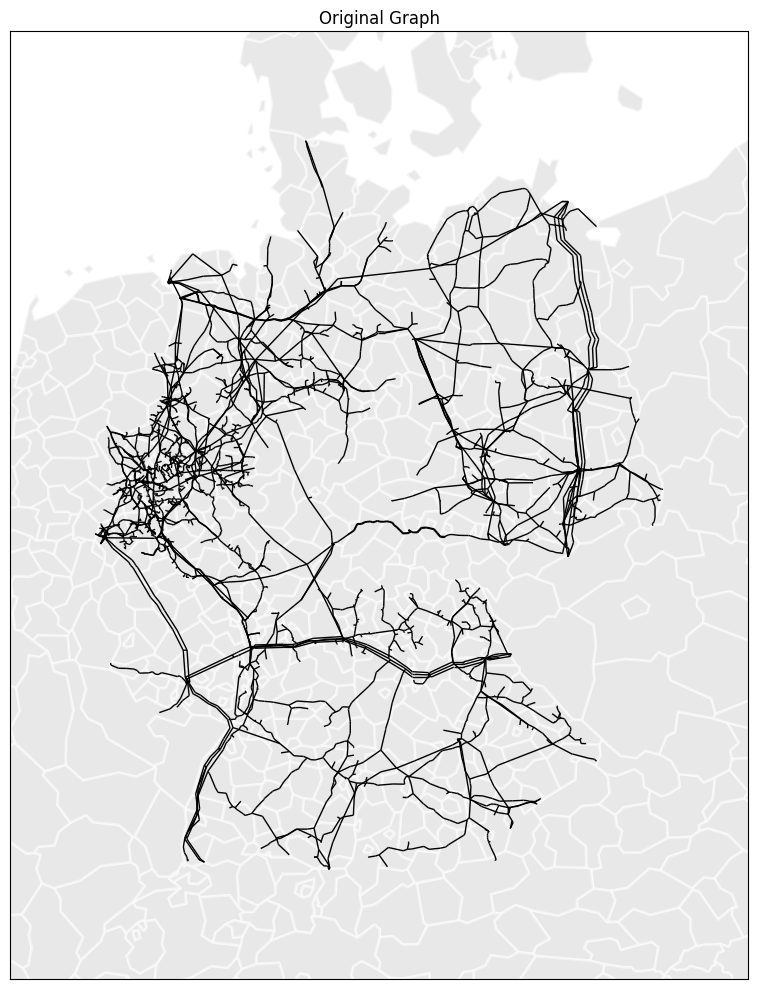

In [772]:
functions.plot_network(
	graph=original,
	gdf=nuts3.to_crs("EPSG:3035"),
	title="Original Graph",
	nodes=False
)

# Run the Algorithms

In [240]:
from networkx.algorithms.community import greedy_modularity_communities, louvain_communities

In [710]:
greedy_modularity_results = functions.run_algo(original, greedy_modularity_communities)

Gefundene Communities: 73
Modularität Q = 0.9597823559978254


In [711]:
greedy_modularity_graph = functions.build_results_graph(original, results=greedy_modularity_results)

In [713]:
louvain_results = functions.run_algo(original, partial(louvain_communities, seed=42))

Gefundene Communities: 69
Modularität Q = 0.9600036377459191


In [714]:
louvain_graph = functions.build_results_graph(original, results=louvain_results)

In [716]:
cores = algos.core.k_core(original, 2)

# Visualization and Investigation

In [712]:
functions.score(original, greedy_modularity_graph, nuts3, verbose=True)

nodes_score: 0.009245187436676799
edges_score: 0.017215482380127094
avg_degree_score: 1.862102039362788
complexity: 0.37047909694013603

structure: 0

original regions: 344
simplified regions: 62
regionality: 0.18023255813953487

original properties: 6022.75
simplified properties: 6022.75
properties: 1.0



0.3876779137699177

In [715]:
functions.score(original, louvain_graph, nuts3, verbose=True)

nodes_score: 0.008738601823708206
edges_score: 0.016984402079722703
avg_degree_score: 1.943606359731746
complexity: 0.34355687878827446

structure: 0

original regions: 344
simplified regions: 59
regionality: 0.17151162790697674

original properties: 6022.75
simplified properties: 6022.75
properties: 1.0



0.3787671266738128

In [717]:
functions.score(original, cores, nuts3, verbose=True)

nodes_score: 0.620694022289767
edges_score: 0.6539572501444252
avg_degree_score: 1.0535903789309082
complexity: 0.22391944954496656

structure: 0

original regions: 344
simplified regions: 278
regionality: 0.8081395348837209

original properties: 6022.75
simplified properties: 3571.5
properties: 0.593001535843261



0.40626513006798715

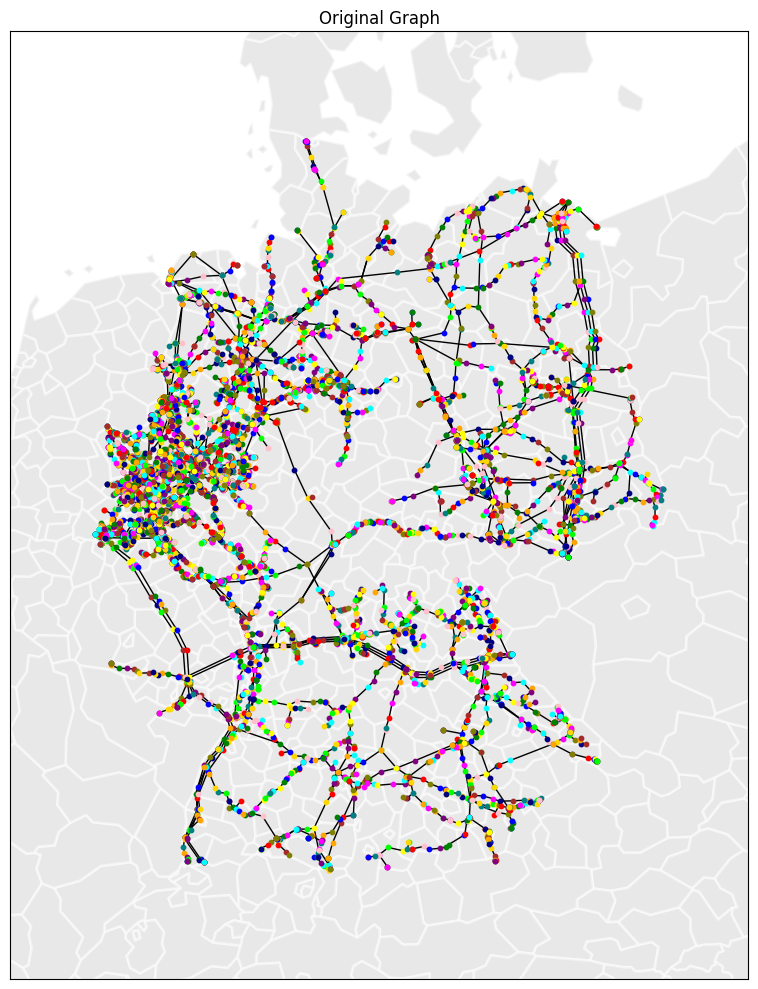

In [763]:
functions.plot_network(
	graph=original,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=10, 
	title="Original Graph"
)

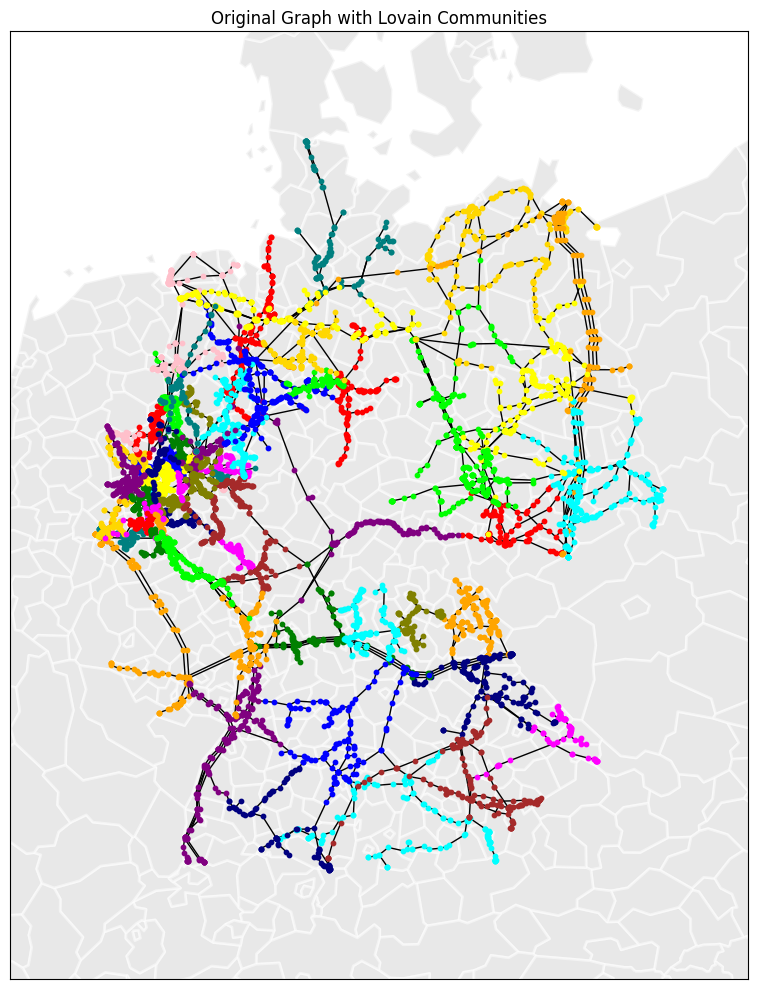

In [764]:
functions.plot_network(
	graph=original,
	gdf=nuts3.to_crs("EPSG:3035"),
	clusters=louvain_results,
	node_size=10, 
	title="Original Graph with Lovain Communities"
)

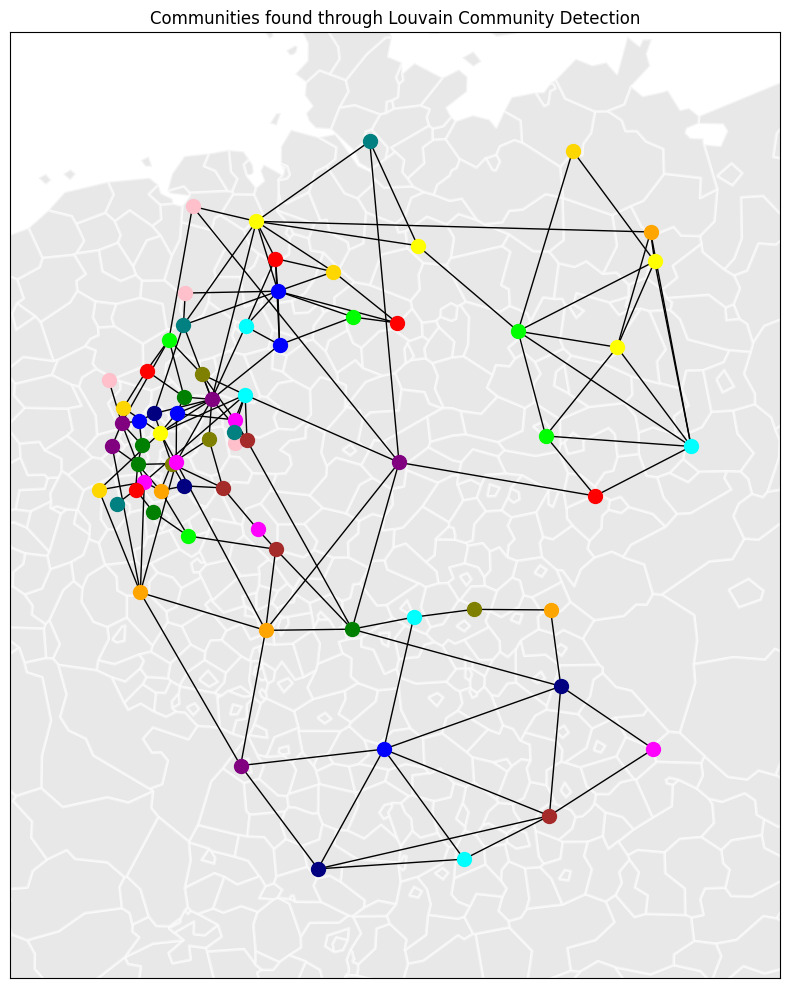

In [765]:
functions.plot_network(
	graph=louvain_graph,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=100, 
	title="Communities found through Louvain Community Detection"
)

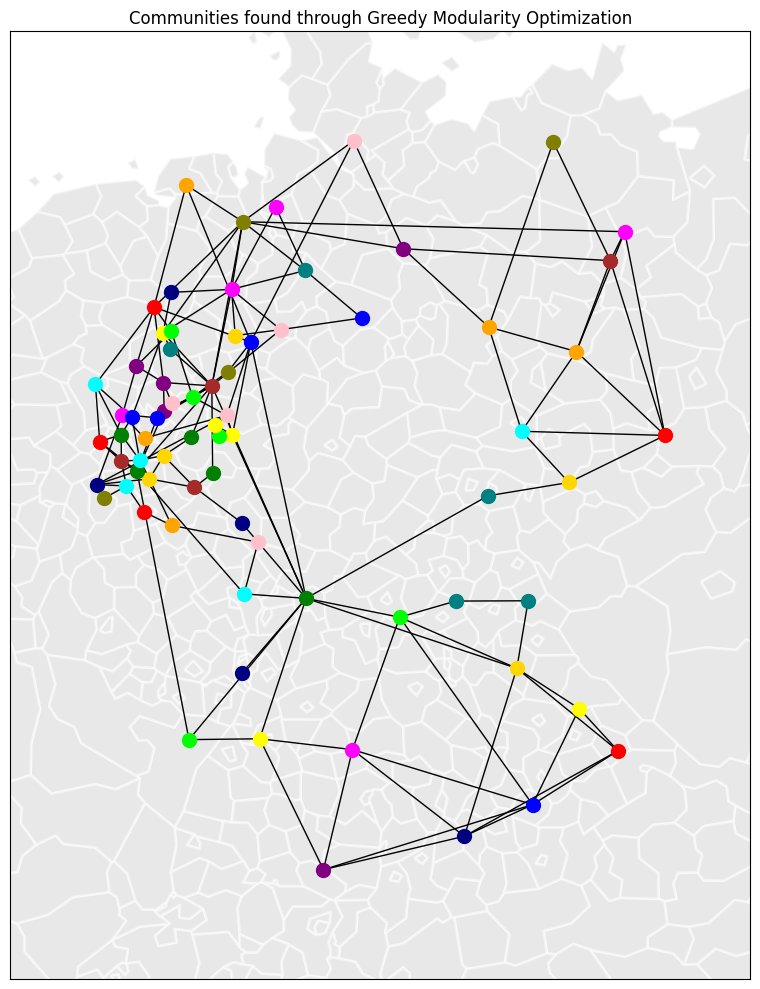

In [766]:
functions.plot_network(
	graph=greedy_modularity_graph,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=100, 
	title="Communities found through Greedy Modularity Optimization"
)

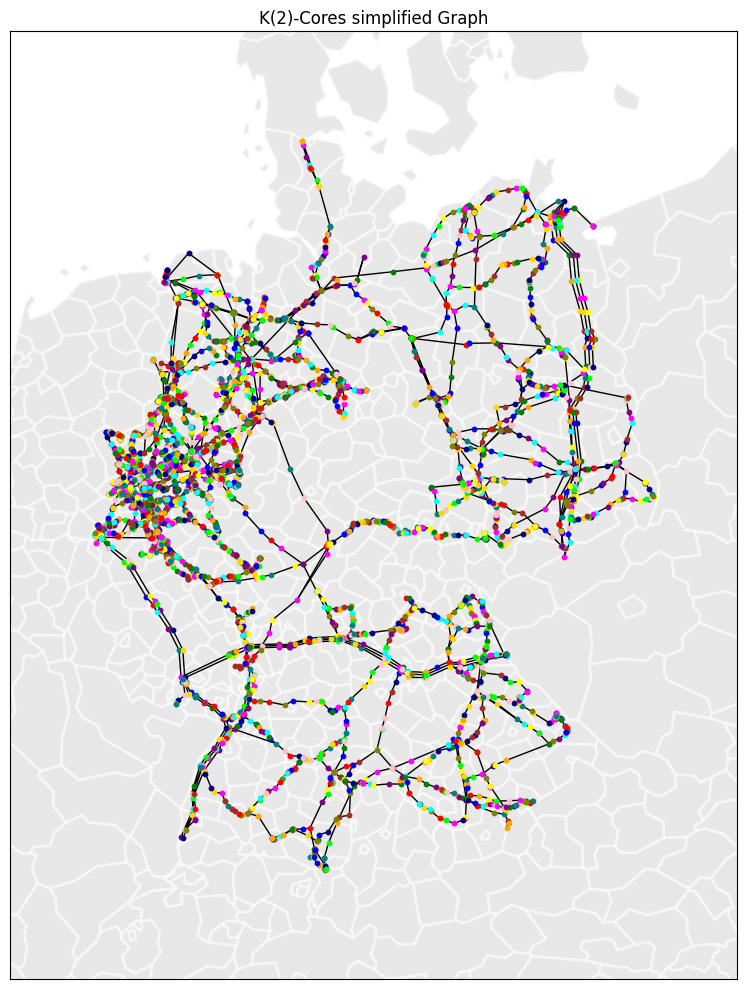

In [767]:
functions.plot_network(
	graph=cores,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=10, 
	title="K(2)-Cores simplified Graph"
	)